In [1]:
!pip install statsmodels
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta


In [2]:
data = pd.read_csv('parkingLot.csv')
data['timestamp']=pd.to_datetime(data['timestamp'])
entry_data = data[data['camera_id'] == 1]
exit_data = data[data['camera_id'] == 2]
merged_data = pd.merge(entry_data, exit_data, on='vehicle_no', suffixes=('_entry', '_exit'))
merged_data['time_spent'] = (merged_data['timestamp_exit'] - merged_data['timestamp_entry']).dt.total_seconds() / 60
merged_data = merged_data[merged_data['time_spent'] > 0]
merged_data['date'] = merged_data['timestamp_entry'].dt.date
daily_avg_time = merged_data.groupby('date')['time_spent'].mean()
daily_avg_time = daily_avg_time.reset_index()
daily_avg_time['date'] = pd.to_datetime(daily_avg_time['date'])
daily_avg_time.set_index('date', inplace=True)

In [3]:
strategy1 = daily_avg_time.copy()
strategy1['time_spent'] = strategy1['time_spent'].interpolate(method='time')
strategy2 = daily_avg_time.copy()
strategy2['time_spent'] = strategy2['time_spent'].fillna(method='ffill')


/tmp/ipykernel_116020/1681331476.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  strategy2['time_spent'] = strategy2['time_spent'].fillna(method='ffill')


In [5]:
train1, test1 = strategy1.iloc[:-7], strategy1.iloc[-7:]
train2, test2 = strategy2.iloc[:-7], strategy2.iloc[-7:]
arima_model1 = ARIMA(train1['time_spent'], order=(5, 1, 0)).fit()#strat 1
arima_forecast1 = arima_model1.forecast(steps=7)
ets_model1 = ExponentialSmoothing(train1['time_spent'], seasonal='add', seasonal_periods=7).fit()
ets_forecast1 = ets_model1.forecast(steps=7)
arima_model2 = ARIMA(train2['time_spent'], order=(5, 1, 0)).fit()#strat 2
arima_forecast2 = arima_model2.forecast(steps=7)
ets_model2 = ExponentialSmoothing(train2['time_spent'], seasonal='add', seasonal_periods=7).fit()
ets_forecast2 = ets_model2.forecast(steps=7)

/mnt/c/Users/D/Downloads/repo/git/Data-Davinci/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/mnt/c/Users/D/Downloads/repo/git/Data-Davinci/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/mnt/c/Users/D/Downloads/repo/git/Data-Davinci/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/mnt/c/Users/D/Downloads/repo/git/Data-Davinci/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/mnt/c/Users/D/Downloads/rep

In [6]:
mase_arima1 = mean_absolute_error(test1['time_spent'], arima_forecast1) / mean_absolute_error(train1['time_spent'], [train1['time_spent'].mean()] * len(train1))
mape_arima1 = np.mean(np.abs((test1['time_spent'] - arima_forecast1) / test1['time_spent'])) * 100
mase_ets1 = mean_absolute_error(test1['time_spent'], ets_forecast1) / mean_absolute_error(train1['time_spent'], [train1['time_spent'].mean()] * len(train1))
mape_ets1 = np.mean(np.abs((test1['time_spent'] - ets_forecast1) / test1['time_spent'])) * 100
mase_arima2 = mean_absolute_error(test2['time_spent'], arima_forecast2) / mean_absolute_error(train2['time_spent'], [train2['time_spent'].mean()] * len(train2))
mape_arima2 = np.mean(np.abs((test2['time_spent'] - arima_forecast2) / test2['time_spent'])) * 100
mase_ets2 = mean_absolute_error(test2['time_spent'], ets_forecast2) / mean_absolute_error(train2['time_spent'], [train2['time_spent'].mean()] * len(train2))
mape_ets2 = np.mean(np.abs((test2['time_spent'] - ets_forecast2) / test2['time_spent'])) * 100

Strategy 1 - Interpolation
ARIMA - MASE: 0.0882156551681503, MAPE: 94.39604514826208
ETS - MASE: 0.10913463408387818, MAPE: 130.0738797332031

Strategy 2 - Forward Fill
ARIMA - MASE: 0.0882156551681503, MAPE: 94.39604514826208
ETS - MASE: 0.10913463408387818, MAPE: 130.0738797332031


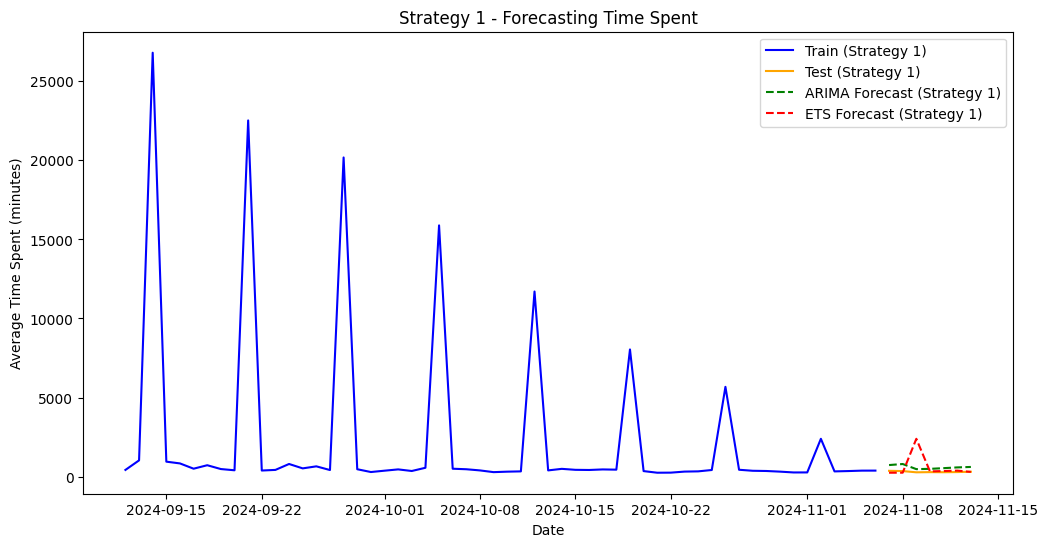

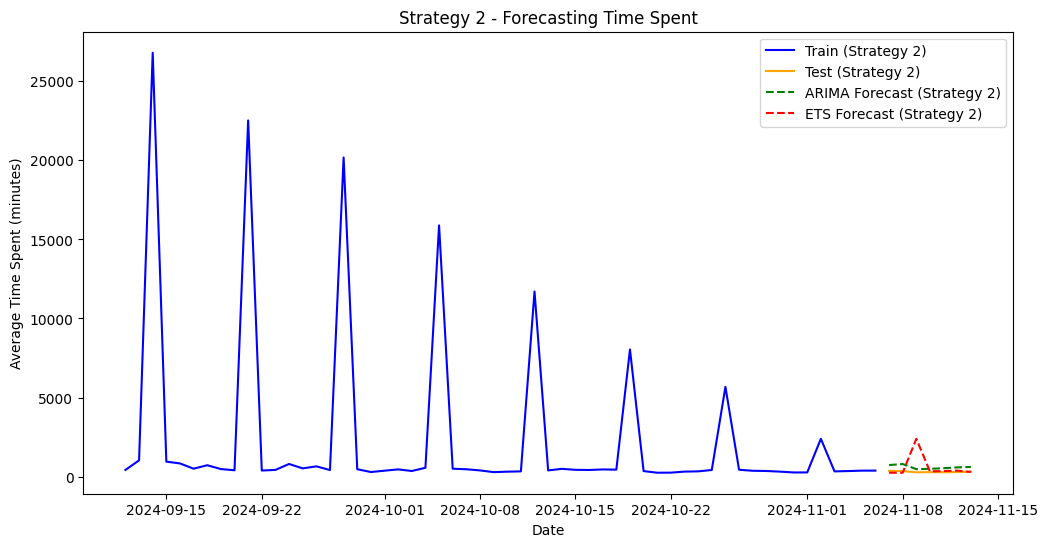

In [8]:

print("Strategy 1 - Interpolation")
print(f"ARIMA - MASE: {mase_arima1}, MAPE: {mape_arima1}")
print(f"ETS - MASE: {mase_ets1}, MAPE: {mape_ets1}")
print("\nStrategy 2 - Forward Fill")
print(f"ARIMA - MASE: {mase_arima2}, MAPE: {mape_arima2}")
print(f"ETS - MASE: {mase_ets2}, MAPE: {mape_ets2}")
plt.figure(figsize=(12, 6))
plt.plot(train1.index, train1['time_spent'], label='Train (Strategy 1)', color='blue')
plt.plot(test1.index, test1['time_spent'], label='Test (Strategy 1)', color='orange')
plt.plot(test1.index, arima_forecast1, label='ARIMA Forecast (Strategy 1)', linestyle='--', color='green')
plt.plot(test1.index, ets_forecast1, label='ETS Forecast (Strategy 1)', linestyle='--', color='red')
plt.legend()
plt.title('Strategy 1 - Forecasting Time Spent')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (minutes)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train2.index, train2['time_spent'], label='Train (Strategy 2)', color='blue')
plt.plot(test2.index, test2['time_spent'], label='Test (Strategy 2)', color='orange')
plt.plot(test2.index, arima_forecast2, label='ARIMA Forecast (Strategy 2)', linestyle='--', color='green')
plt.plot(test2.index, ets_forecast2, label='ETS Forecast (Strategy 2)', linestyle='--', color='red')
plt.legend()
plt.title('Strategy 2 - Forecasting Time Spent')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (minutes)')
plt.show()